In [16]:
import sqlite3
import pandas as pd
import re
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB, BernoulliNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import LinearSVC
from sklearn.metrics import (classification_report, confusion_matrix, accuracy_score,
                             precision_recall_fscore_support, roc_auc_score)

In [17]:
print("Łączenie z bazą danych")
conn = sqlite3.connect('reviews.db')
query = """
SELECT 
    review, 
    voted_up,
    written_during_early_access,
    author_playtime_forever, 
    author_playtime_last_two_weeks,
    author_last_played,
    author_playtime_at_review,
    author_num_reviews, 
    "author.num_games_owned", 
    votes_up, 
    language
FROM reviews
"""
df = pd.read_sql(query, conn)
df['author_playtime_hours'] = df['author_playtime_forever'] / 60
conn.close()

print(f"Wczytano {len(df)} recenzji.")

Łączenie z bazą danych
Wczytano 15586 recenzji.


In [18]:
df.head()

,review,voted_up,written_during_early_access,author_playtime_forever,author_playtime_last_two_weeks,author_last_played,author_playtime_at_review,author_num_reviews,author.num_games_owned,votes_up,language,author_playtime_hours
0,Pretty good game all around.\r\nGreat game! I ...,1,0,44277,1075,2023-03-01 09:04:32,44277,1,8,0,english,737.950000
1,haha smiriva me\r\n,1,0,2169,2169,2023-03-01 09:16:29,2169,1,1,0,english,36.150000
2,full of cheaterts roblox has better anti cheat,0,0,15619,1976,2023-03-01 09:15:00,15603,3,18,0,english,260.316667
3,"Good game, kinda racist but good.",1,0,14826,2452,2023-02-27 21:09:37,14826,1,10,0,english,247.100000
4,mrazq rusnacite ama ovr stava,1,0,5045,400,2023-03-01 09:30:07,4984,1,10,0,english,84.083333


In [19]:
# ===== PARAMETRY FILTROWANIA (ELASTYCZNE) =====
min_godzin = 50       
min_recenzji = 1
wybrany_jezyk = 'english' 
min_votes_up = 1
posiadane_gry = 1

df_filtered = df[
    (df['author_playtime_hours'] >= min_godzin) &
    (df['author_num_reviews'] >= min_recenzji) &
    (df['language'] == wybrany_jezyk) &
    (df['votes_up'] >= min_votes_up) &
    (df['author.num_games_owned'] >= posiadane_gry)
].copy()

print(f"Liczba rekordów przed filtrowaniem: {len(df)}")
print(f"Liczba rekordów po filtrowaniu: {len(df_filtered)}")
print(f"\n Statystyka metadanych:")
print(f"  Średni czas gry: {df['author_playtime_hours'].mean():.1f}h")
print(f"  Średnia liczba recenzji: {df['author_num_reviews'].mean():.1f}")
print(f"  Średnia liczba głosów: {df['votes_up'].mean():.1f}")
print(f"  Rozkład ocen: {df['voted_up'].value_counts().to_dict()}")

Liczba rekordów przed filtrowaniem: 15586
Liczba rekordów po filtrowaniu: 1672

 Statystyka metadanych:
  Średni czas gry: 448.6h
  Średnia liczba recenzji: 3.1
  Średnia liczba głosów: 0.3
  Rozkład ocen: {1: 13935, 0: 1651}


In [20]:
def clean_text(text):
    if text is None: return ""
    text = str(text).lower()
    # -hmtl (<br>)
    text = re.sub(r'<.*?>', '', text)
    # - znaki specjalne  tylko litery i spacje
    text = re.sub(r'[^a-z\s]', '', text)
    # - spacje
    text = re.sub(r'\s+', ' ', text).strip()
    return text

In [21]:
print("Czyszczenie tekstu...")
df['clean_review'] = df['review'].apply(clean_text)
df['review_length'] = df['clean_review'].str.len()
df['word_count'] = df['clean_review'].str.split().str.len()
df_filtered['clean_review'] = df_filtered['review'].apply(clean_text)
df_filtered['review_length'] = df_filtered['clean_review'].str.len()
df_filtered['word_count'] = df_filtered['clean_review'].str.split().str.len()
print(f"Średnia długość recenzji: {df['review_length'].mean():.0f} znaków")
print(f"Średnia liczba słów: {df['word_count'].mean():.0f} słów")

Czyszczenie tekstu...
Średnia długość recenzji: 42 znaków
Średnia liczba słów: 8 słów


In [22]:
# ===== TF-IDF WEKTORYZACJA =====
print("Wektoryzacja TF-IDF...")
tfidf = TfidfVectorizer(max_features=2000, stop_words='english', min_df=5, max_df=0.8)
X = tfidf.fit_transform(df['clean_review'])
y = df['voted_up']

print(f"Wymiary wektora: {X.shape}")
print(f"Sparsity: {X.nnz / (X.shape[0] * X.shape[1]) * 100:.2f}%")

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
print(f"Train set: {X_train.shape[0]}, Test set: {X_test.shape[0]}")

Wektoryzacja TF-IDF...
Wymiary wektora: (15586, 1735)
Sparsity: 0.18%
Train set: 12468, Test set: 3118


In [23]:
tfidf

,input,'content'
,encoding,'utf-8'
,decode_error,'strict'
,strip_accents,None
,lowercase,True
,preprocessor,None
,tokenizer,None
,analyzer,'word'
,stop_words,'english'
,token_pattern,'(?u)\\b\\w\\w+\\b'
,ngram_range,"(1, ...)"


In [24]:
# ===== TRENOWANIE MODELI KLASYFIKACJI =====
print("\n Trenowanie modeli...\n")

# Słownik na wyniki
results = {}

# 1. Multinomial Naive Bayes
model = MultinomialNB(alpha=1.0)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

acc = accuracy_score(y_test, y_pred)
precision, recall, f1, _ = precision_recall_fscore_support(y_test, y_pred, average='weighted')

results['Multinomial NB'] = {
    'model': model,
    'pred': y_pred,
    'acc': acc,
    'precision': precision,
    'recall': recall,
    'f1': f1,
}

print(f"1. Multinomial Naive Bayes:")
print(f"    Accuracy: {acc:.4f} | Precision: {precision:.4f} | Recall: {recall:.4f} | F1: {f1:.4f}")

# 2. Bernoulli Naive Bayes
ber_model = BernoulliNB(alpha=1.0)
ber_model.fit(X_train, y_train)
y_pred_ber = ber_model.predict(X_test)

acc_ber = accuracy_score(y_test, y_pred_ber)
precision_ber, recall_ber, f1_ber, _ = precision_recall_fscore_support(y_test, y_pred_ber, average='weighted')

results['Bernoulli NB'] = {
    'model': ber_model,
    'pred': y_pred_ber,
    'acc': acc_ber,
    'precision': precision_ber,
    'recall': recall_ber,
    'f1': f1_ber,
}

print(f"2. Bernoulli Naive Bayes:")
print(f"    Accuracy: {acc_ber:.4f} | Precision: {precision_ber:.4f} | Recall: {recall_ber:.4f} | F1: {f1_ber:.4f}")

# 3. LinearSVC
svm_model = LinearSVC(random_state=42, max_iter=2000, C=1.0)
svm_model.fit(X_train, y_train)
y_pred_svm = svm_model.predict(X_test)

acc_svm = accuracy_score(y_test, y_pred_svm)
precision_svm, recall_svm, f1_svm, _ = precision_recall_fscore_support(y_test, y_pred_svm, average='weighted')

results['LinearSVC'] = {
    'model': svm_model,
    'pred': y_pred_svm,
    'acc': acc_svm,
    'precision': precision_svm,
    'recall': recall_svm,
    'f1': f1_svm
}

print(f"3. LinearSVC (SVM):")
print(f"    Accuracy: {acc_svm:.4f} | Precision: {precision_svm:.4f} | Recall: {recall_svm:.4f} | F1: {f1_svm:.4f}")

# 4. k-Nearest Neighbors
knn_model = KNeighborsClassifier(n_neighbors=5, n_jobs=-1)
knn_model.fit(X_train, y_train)
y_pred_knn = knn_model.predict(X_test)

acc_knn = accuracy_score(y_test, y_pred_knn)
precision_knn, recall_knn, f1_knn, _ = precision_recall_fscore_support(y_test, y_pred_knn, average='weighted')

results['k-NN (k=5)'] = {
    'model': knn_model,
    'pred': y_pred_knn,
    'acc': acc_knn,
    'precision': precision_knn,
    'recall': recall_knn,
    'f1': f1_knn,
}

print(f"4. k-Nearest Neighbors (k=5):")
print(f"    Accuracy: {acc_knn:.4f} | Precision: {precision_knn:.4f} | Recall: {recall_knn:.4f} | F1: {f1_knn:.4f}")

# 5. Random Forest
rf_model = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1, max_depth=15)
rf_model.fit(X_train, y_train)
y_pred_rf = rf_model.predict(X_test)

acc_rf = accuracy_score(y_test, y_pred_rf)
precision_rf, recall_rf, f1_rf, _ = precision_recall_fscore_support(y_test, y_pred_rf, average='weighted')

results['Random Forest'] = {
    'model': rf_model,
    'pred': y_pred_rf,
    'acc': acc_rf,
    'precision': precision_rf,
    'recall': recall_rf,
    'f1': f1_rf,
}

print(f"5. Random Forest:")
print(f"    Accuracy: {acc_rf:.4f} | Precision: {precision_rf:.4f} | Recall: {recall_rf:.4f} | F1: {f1_rf:.4f} ")

# 6. Gradient Boosting
gb_model = GradientBoostingClassifier(n_estimators=100, random_state=42, learning_rate=0.1, max_depth=5)
gb_model.fit(X_train, y_train)
y_pred_gb = gb_model.predict(X_test)

acc_gb = accuracy_score(y_test, y_pred_gb)
precision_gb, recall_gb, f1_gb, _ = precision_recall_fscore_support(y_test, y_pred_gb, average='weighted')

results['Gradient Boosting'] = {
    'model': gb_model,
    'pred': y_pred_gb,
    'acc': acc_gb,
    'precision': precision_gb,
    'recall': recall_gb,
    'f1': f1_gb,
}

print(f"6. Gradient Boosting:")
print(f"    Accuracy: {acc_gb:.4f} | Precision: {precision_gb:.4f} | Recall: {recall_gb:.4f} | F1: {f1_gb:.4f} ")




 Trenowanie modeli...

1. Multinomial Naive Bayes:
    Accuracy: 0.8954 | Precision: 0.8629 | Recall: 0.8954 | F1: 0.8585
2. Bernoulli Naive Bayes:
    Accuracy: 0.8778 | Precision: 0.8614 | Recall: 0.8778 | F1: 0.8683
3. LinearSVC (SVM):
    Accuracy: 0.9076 | Precision: 0.8917 | Recall: 0.9076 | F1: 0.8930
4. k-Nearest Neighbors (k=5):
    Accuracy: 0.8884 | Precision: 0.8544 | Recall: 0.8884 | F1: 0.8630
5. Random Forest:
    Accuracy: 0.8948 | Precision: 0.9059 | Recall: 0.8948 | F1: 0.8458 
6. Gradient Boosting:
    Accuracy: 0.9019 | Precision: 0.8828 | Recall: 0.9019 | F1: 0.8714 


In [25]:
# ===== PODSUMOWANIE WYNIKÓW WSZYSTKICH MODELI =====
print("\n PODSUMOWANIE WYNIKÓW WSZYSTKICH MODELI:\n")

results_df = pd.DataFrame([
    {'Model': k, 'Accuracy': v['acc'], 'Precision': v['precision'], 
     'Recall': v['recall'], 'F1-Score': v['f1']}
    for k, v in results.items()
])

print(results_df.to_string(index=False))
print(f"\nNajlepszy model: {results_df.loc[results_df['F1-Score'].idxmax(), 'Model']} (F1={results_df['F1-Score'].max():.4f})")


 PODSUMOWANIE WYNIKÓW WSZYSTKICH MODELI:

            Model  Accuracy  Precision   Recall  F1-Score
   Multinomial NB  0.895446   0.862907 0.895446  0.858493
     Bernoulli NB  0.877806   0.861424 0.877806  0.868324
        LinearSVC  0.907633   0.891749 0.907633  0.892977
       k-NN (k=5)  0.888390   0.854396 0.888390  0.862966
    Random Forest  0.894804   0.905878 0.894804  0.845762
Gradient Boosting  0.901860   0.882826 0.901860  0.871365

Najlepszy model: LinearSVC (F1=0.8930)


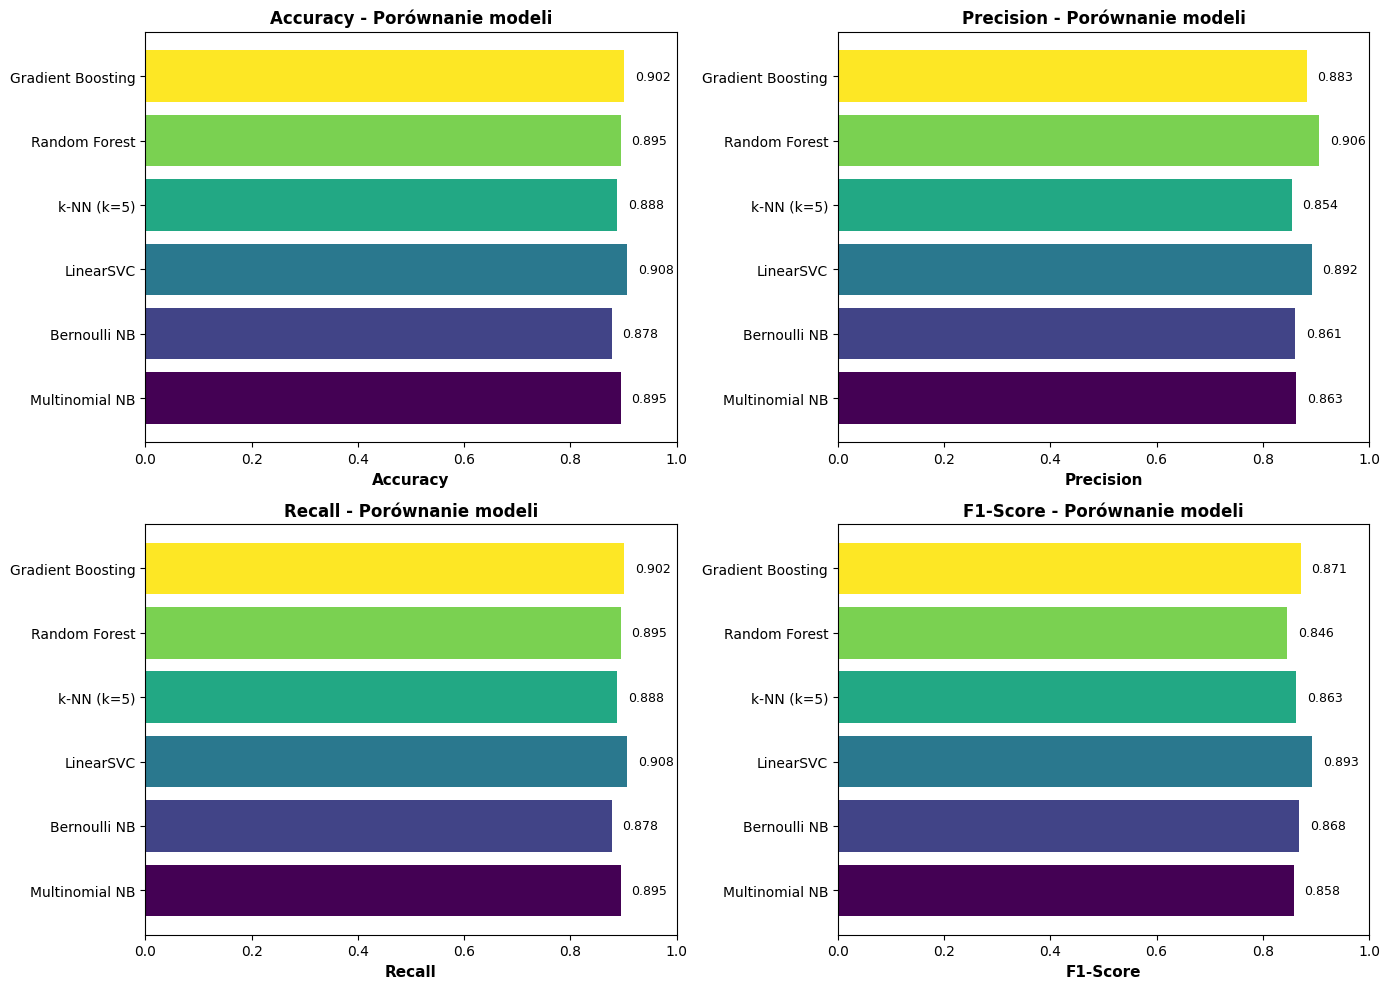

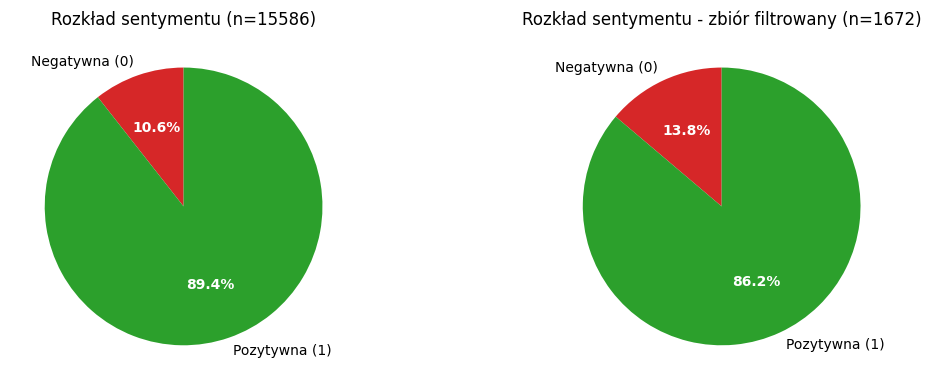

In [26]:
# ===== WIZUALIZACJE =====
# Porównanie metryk między modelami
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score']
for idx, metric in enumerate(metrics):
    ax = axes[idx // 2, idx % 2]
    colors = plt.cm.viridis(np.linspace(0, 1, len(results_df)))
    bars = ax.barh(results_df['Model'], results_df[metric], color=colors)
    ax.set_xlabel(metric, fontsize=11, fontweight='bold')
    ax.set_title(f'{metric} - Porównanie modeli', fontsize=12, fontweight='bold')
    ax.set_xlim([0, 1])
    
    # Etykiety wartości na słupkach
    for bar, val in zip(bars, results_df[metric]):
        ax.text(val + 0.02, bar.get_y() + bar.get_height()/2, f'{val:.3f}', 
                va='center', fontsize=9)

plt.tight_layout()
plt.show()

# Rozkład recenzji (sentyment)
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Rozkład na całym zbiorze
ax1 = axes[0]
sentiment_counts = df['voted_up'].value_counts().sort_index()
colors_sentiment = ['#d62728', '#2ca02c']
wedges, texts, autotexts = ax1.pie(sentiment_counts, labels=['Negatywna (0)', 'Pozytywna (1)'], 
                                     autopct='%1.1f%%', colors=colors_sentiment, startangle=90)
for autotext in autotexts:
    autotext.set_color('white')
    autotext.set_fontweight('bold')
ax1.set_title(f'Rozkład sentymentu (n={len(df)})')

# Rozkład na zbiorze filtrowanym
ax2 = axes[1]
sentiment_counts_filt = df_filtered['voted_up'].value_counts().sort_index()
wedges, texts, autotexts = ax2.pie(sentiment_counts_filt, labels=['Negatywna (0)', 'Pozytywna (1)'], 
                                     autopct='%1.1f%%', colors=colors_sentiment, startangle=90)
for autotext in autotexts:
    autotext.set_color('white')
    autotext.set_fontweight('bold')
ax2.set_title(f'Rozkład sentymentu - zbiór filtrowany (n={len(df_filtered)})')

plt.tight_layout()
plt.show()

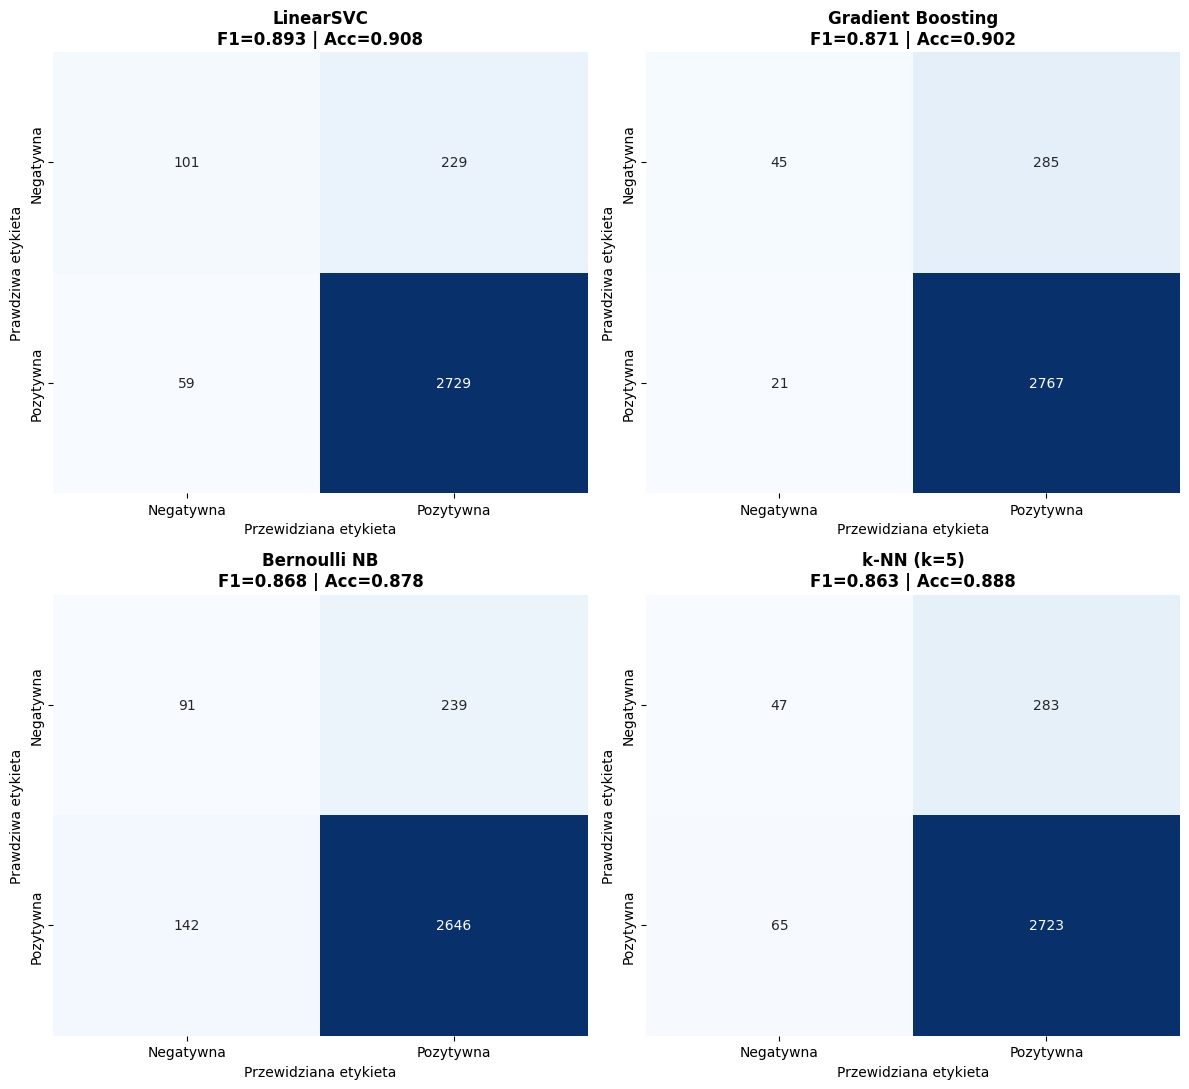


 Macierze pomyłek wygenerowane dla 4 najlepszych modeli


In [27]:
# Macierze pomyłek dla najlepszych modeli
top_models = results_df.nlargest(4, 'F1-Score')['Model'].tolist()
fig, axes = plt.subplots(2, 2, figsize=(12, 11))
axes = axes.flatten()

for idx, model_name in enumerate(top_models):
    y_pred_model = results[model_name]['pred']
    cm = confusion_matrix(y_test, y_pred_model)
    
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[idx], cbar=False,
                xticklabels=['Negatywna', 'Pozytywna'],
                yticklabels=['Negatywna', 'Pozytywna'])
    
    # Dodaj metryki na tytuł
    f1_val = results[model_name]['f1']
    acc_val = results[model_name]['acc']
    axes[idx].set_title(f'{model_name}\nF1={f1_val:.3f} | Acc={acc_val:.3f}', fontweight='bold')
    axes[idx].set_ylabel('Prawdziwa etykieta')
    axes[idx].set_xlabel('Przewidziana etykieta')

plt.tight_layout()
plt.show()

print("\n Macierze pomyłek wygenerowane dla 4 najlepszych modeli")


Generowanie analiz słów...


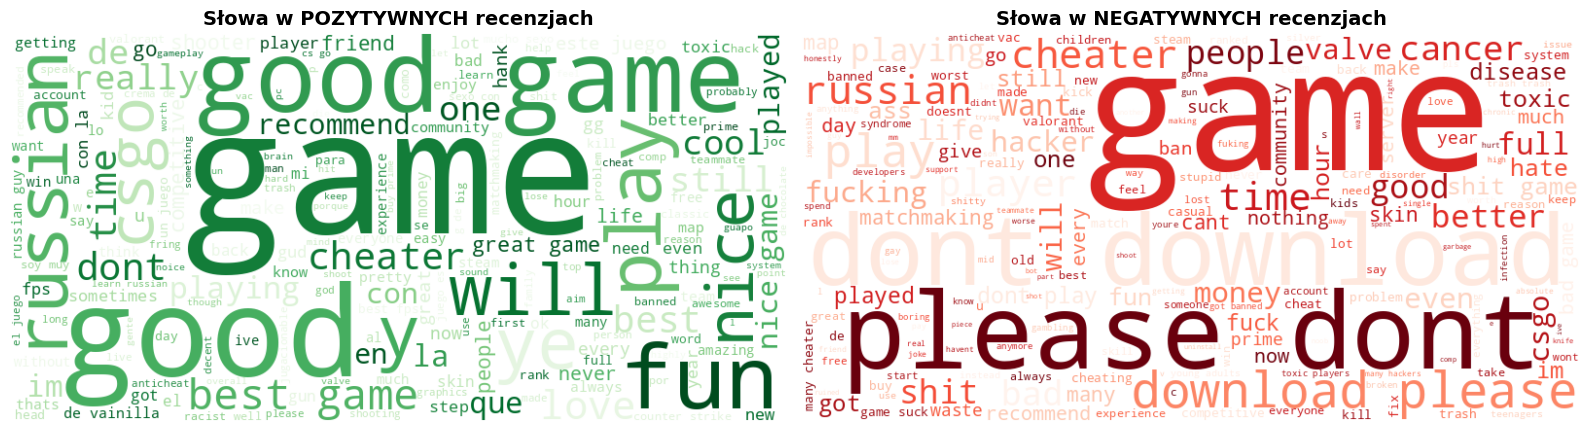


Top 15 słów w recenzjach POZYTYWNYCH (wg TF-IDF):
   1. good                 | waga: 0.1165
   2. game                 | waga: 0.1133
   3. nice                 | waga: 0.0446
   4. best                 | waga: 0.0344
   5. fun                  | waga: 0.0339
   6. yes                  | waga: 0.0269
   7. like                 | waga: 0.0172
   8. great                | waga: 0.0169
   9. love                 | waga: 0.0161
  10. play                 | waga: 0.0151
  11. gud                  | waga: 0.0121
  12. cool                 | waga: 0.0116
  13. russian              | waga: 0.0114
  14. csgo                 | waga: 0.0090
  15. gg                   | waga: 0.0081

Top 15 słów w recenzjach NEGATYWNYCH (wg TF-IDF):
   1. game                 | waga: 0.0754
   2. bad                  | waga: 0.0381
   3. shit                 | waga: 0.0373
   4. dont                 | waga: 0.0287
   5. play                 | waga: 0.0265
   6. cheaters             | waga: 0.0262
   7. just      

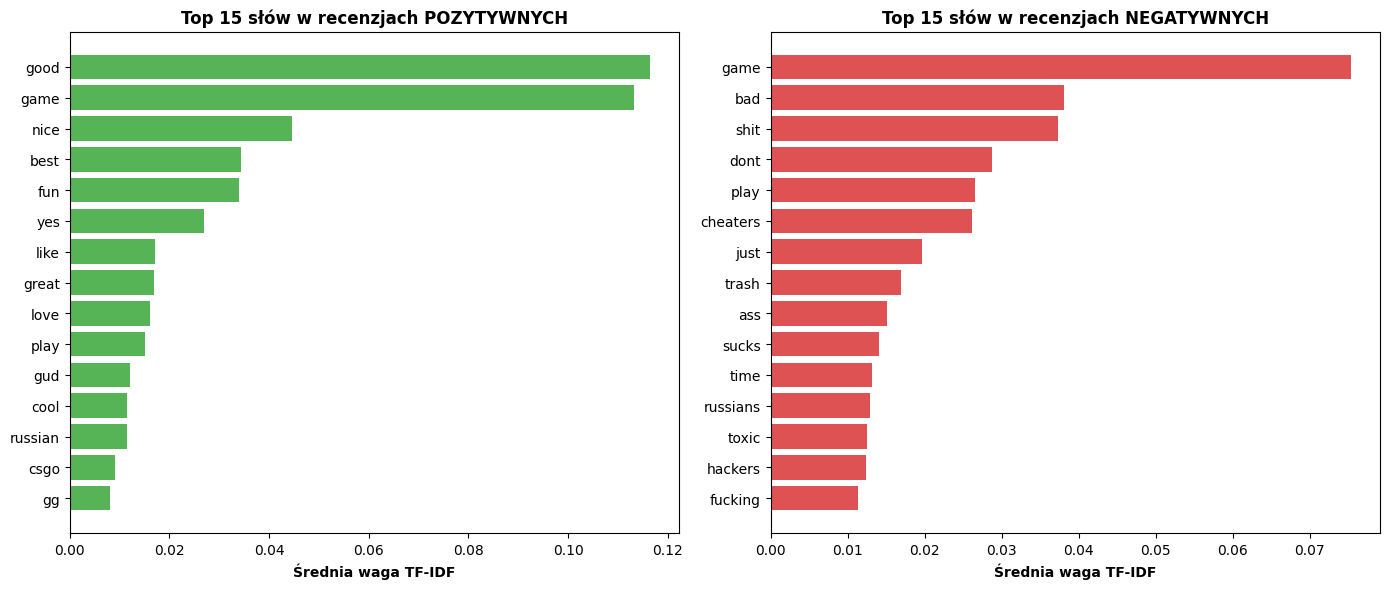

In [28]:
# Chmury słów dla różnych sentimentów + analiza TF-IDF
print("\nGenerowanie analiz słów...")

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Pozytywne recenzje
positive_text = " ".join(df[df['voted_up'] == 1]['clean_review'].sample(min(1000, len(df[df['voted_up'] == 1]))).values)
wordcloud_pos = WordCloud(width=800, height=400, background_color='white', colormap='Greens').generate(positive_text)
axes[0].imshow(wordcloud_pos, interpolation='bilinear')
axes[0].axis('off')
axes[0].set_title('Słowa w POZYTYWNYCH recenzjach', fontsize=14, fontweight='bold')

# Negatywne recenzje
negative_text = " ".join(df[df['voted_up'] == 0]['clean_review'].sample(min(1000, len(df[df['voted_up'] == 0]))).values)
wordcloud_neg = WordCloud(width=800, height=400, background_color='white', colormap='Reds').generate(negative_text)
axes[1].imshow(wordcloud_neg, interpolation='bilinear')
axes[1].axis('off')
axes[1].set_title('Słowa w NEGATYWNYCH recenzjach', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()

# Analiza terminów z największą wagą TF-IDF
feature_names = np.array(tfidf.get_feature_names_out())

# Top słowa pozytywne
positive_indices = (y == 1).values
positive_X = X[positive_indices]
positive_mean = np.asarray(positive_X.mean(axis=0)).ravel()
top_positive_idx = positive_mean.argsort()[-15:][::-1]

print("\nTop 15 słów w recenzjach POZYTYWNYCH (wg TF-IDF):")
for i, idx in enumerate(top_positive_idx, 1):
    print(f"  {i:2d}. {feature_names[idx]:20s} | waga: {positive_mean[idx]:.4f}")

# Top słowa negatywne
negative_indices = (y == 0).values
negative_X = X[negative_indices]
negative_mean = np.asarray(negative_X.mean(axis=0)).ravel()
top_negative_idx = negative_mean.argsort()[-15:][::-1]

print("\nTop 15 słów w recenzjach NEGATYWNYCH (wg TF-IDF):")
for i, idx in enumerate(top_negative_idx, 1):
    print(f"  {i:2d}. {feature_names[idx]:20s} | waga: {negative_mean[idx]:.4f}")

# Wizualizacja top słów
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

axes[0].barh(feature_names[top_positive_idx], positive_mean[top_positive_idx], color='#2ca02c', alpha=0.8)
axes[0].set_xlabel('Średnia waga TF-IDF', fontweight='bold')
axes[0].set_title('Top 15 słów w recenzjach POZYTYWNYCH', fontsize=12, fontweight='bold')
axes[0].invert_yaxis()

axes[1].barh(feature_names[top_negative_idx], negative_mean[top_negative_idx], color='#d62728', alpha=0.8)
axes[1].set_xlabel('Średnia waga TF-IDF', fontweight='bold')
axes[1].set_title('Top 15 słów w recenzjach NEGATYWNYCH', fontsize=12, fontweight='bold')
axes[1].invert_yaxis()

plt.tight_layout()
plt.show()

In [ ]:
# ===== ZAAWANSOWANA ANALIZA: WYSZUKIWANIE I PODOBIEŃSTWO =====
print("\n" + "="*80)
print("ZAAWANSOWANA ANALIZA: WYSZUKIWANIE PODOBNYCH RECENZJI")
print("="*80)

from sklearn.metrics.pairwise import cosine_similarity

def znajdz_podobne(tekst_recenzji, top_n=5, filtr_sentiment=None):
    """Wyszukiwanie podobnych recenzji z opcjonalnym filtrem sentymentu"""
    vec = tfidf.transform([clean_text(tekst_recenzji)])
    similarity = cosine_similarity(vec, X)[0]
    
    # Aplikuj filtr sentymentu jeśli podany
    if filtr_sentiment is not None:
        mask = y.values == filtr_sentiment
        similarity_filtered = np.full_like(similarity, -1)
        similarity_filtered[mask] = similarity[mask]
        top_indices = similarity_filtered.argsort()[-top_n:][::-1]
        top_indices = top_indices[similarity_filtered[top_indices] != -1]
    else:
        top_indices = similarity.argsort()[-top_n:][::-1]
    
    sentiment_label = {1: '✅ Pozytywna', 0: '❌ Negatywna'}
    
    print(f"\n🔍 Szukanie recenzji podobnych do: '{tekst_recenzji[:60]}...'")
    print(f"   (znaleziono {len(top_indices)} recenzji)\n")
    
    for rank, idx in enumerate(top_indices, 1):
        score = similarity[idx]
        review = df.iloc[idx]['review'][:80] + "..."
        sentiment = sentiment_label[df.iloc[idx]['voted_up']]
        playtime = df.iloc[idx]['author_playtime_hours']
        print(f"  {rank}. [Podobieństwo: {score:.3f}] {sentiment} (Playtime: {playtime:.0f}h)")
        print(f"     → {review}")

# Test z różnymi filtrami
print("\n📌 PRZYKŁAD 1: Recenzja pozytywna")
sample_positive = df[df['voted_up'] == 1]['review'].sample(1).values[0]
znajdz_podobne(sample_positive, top_n=3)

print("\n" + "-"*80)
print("\n📌 PRZYKŁAD 2: Recenzja negatywna")
sample_negative = df[df['voted_up'] == 0]['review'].sample(1).values[0]
znajdz_podobne(sample_negative, top_n=3)

print("\n" + "-"*80)
print("\n📌 PRZYKŁAD 3: Wyszukiwanie tylko wśród recenzji POZYTYWNYCH")
znajdz_podobne(sample_negative, top_n=3, filtr_sentiment=1)

# ===== ANALIZA WPŁYWU METADANYCH NA SENTIMENT =====
print("\n" + "="*80)
print("KORELACJA METADANYCH Z OCENĄ RECENZJI")
print("="*80)

corr_playtime = df['author_playtime_hours'].corr(df['voted_up'])
corr_reviews = df['author_num_reviews'].corr(df['voted_up'])
corr_votes = df['votes_up'].corr(df['voted_up'])
corr_length = df['review_length'].corr(df['voted_up'])
corr_words = df['word_count'].corr(df['voted_up'])

corr_dict = {
    'Czas gry (godziny)': corr_playtime,
    'Liczba recenzji autora': corr_reviews,
    'Przydatne głosy': corr_votes,
    'Długość recenzji (znaki)': corr_length,
    'Liczba słów': corr_words
}

for feature, corr in sorted(corr_dict.items(), key=lambda x: abs(x[1]), reverse=True):
    direction = '📈' if corr > 0 else '📉'
    print(f"{direction} {feature:30s} | Korelacja: {corr:7.4f}")



ZAAWANSOWANA ANALIZA: WYSZUKIWANIE PODOBNYCH RECENZJI

📌 PRZYKŁAD 1: Recenzja pozytywna

🔍 Szukanie recenzji podobnych do: 'GOOD GAME...'
   (znaleziono 3 recenzji)

  1. [Podobieństwo: 1.000] ✅ Pozytywna (Playtime: 70h)
     → good game...
  2. [Podobieństwo: 1.000] ✅ Pozytywna (Playtime: 1952h)
     → good game (: ♡...
  3. [Podobieństwo: 1.000] ✅ Pozytywna (Playtime: 5660h)
     → good  game...

--------------------------------------------------------------------------------

📌 PRZYKŁAD 2: Recenzja negatywna

🔍 Szukanie recenzji podobnych do: 'its okay for 100 hours...'
   (znaleziono 3 recenzji)

  1. [Podobieństwo: 1.000] ❌ Negatywna (Playtime: 5616h)
     → its okay for 100 hours...
  2. [Podobieństwo: 0.857] ✅ Pozytywna (Playtime: 1003h)
     → It's okay, Played it for a few hours....
  3. [Podobieństwo: 0.790] ✅ Pozytywna (Playtime: 5h)
     → its okay...

--------------------------------------------------------------------------------

📌 PRZYKŁAD 3: Wyszukiwanie tylko wśród r